# 過去30日間の各海釣り施設の釣果数

## モジュールのインポート

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [2]:
# プロジェクトディレクトリ以外でjupyter notebook を実行した場合は、以下コマンドで、
# SQLLite3データベースの絶対パスを確認し、次の sqlite3.connect({パス名})文で、
# 指定してください。
from piersfan.config import Config
print(Config.get_db_path())

c:\home\blog\fishing-piers-fan\data\fishing_result.db


In [17]:
# 大黒、アジ以外の魚種で、SQLite3データベースを検索

conn = sqlite3.connect("../data/fishing_result.db")
sql = '''
select
    r.Date,
    r.Point,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Date >= (SELECT datetime(max(Date), '-30 day') from fishing_results)
'''
df=pd.read_sql_query(sql, conn)
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.head()

,Point,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity
Date,,,,,,,
2021-03-25,daikoku,アジ,83,15.0,27.0,13.5,193.0
2021-03-25,daikoku,アナゴ,1,40.0,40.0,13.5,193.0
2021-03-25,daikoku,イシモチ,2,25.0,26.0,13.5,193.0
2021-03-25,daikoku,イワシ,6672,10.0,16.0,13.5,193.0
2021-03-25,daikoku,ウミタナゴ,4,20.0,22.0,13.5,193.0


In [18]:
# 日本語の文字化け対策のため、魚種をローマ字に変換

def get_spieces_alphabet(spieces):
    if spieces == 'アジ':
        return 'Aji'
    if spieces == 'クロダイ':
        return 'Kurodai'
    elif spieces == 'メジナ':
        return 'Mejina'
    elif spieces == 'メバル':
        return 'Mebaru'
    elif spieces == 'カサゴ':
        return 'Kasago'
    else:
        return 'Etc'

df['Species'] = df.apply(lambda x: get_spieces_alphabet(x.Species), axis=1)

In [19]:
# 代表として設定した魚種以外は取り除く
df2 = df[df.Species!='Etc']

<AxesSubplot:xlabel='Date', ylabel='WaterTemp'>

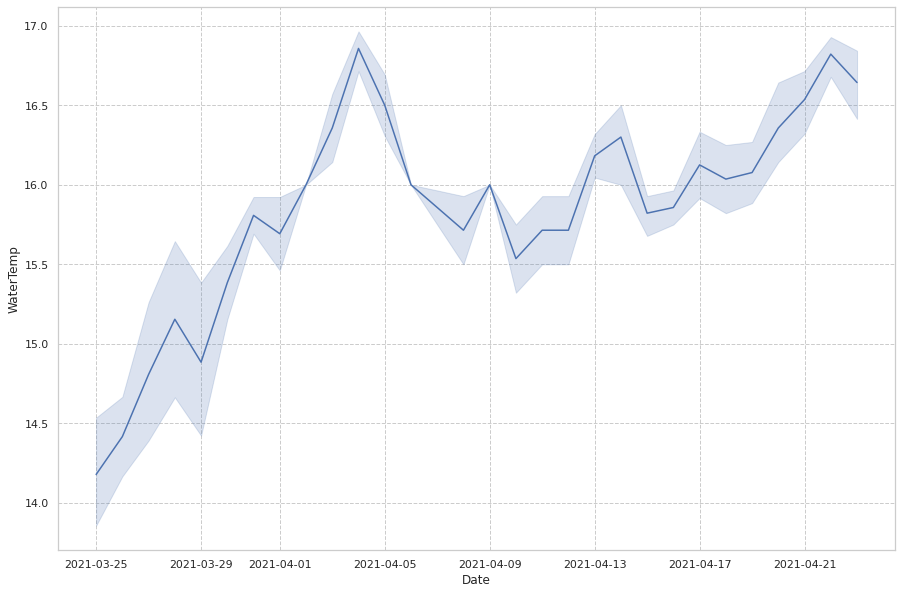

In [20]:
# 海水温の変化
sns.lineplot(data=df2, x="Date", y="WaterTemp")

<AxesSubplot:xlabel='Date', ylabel='Count'>

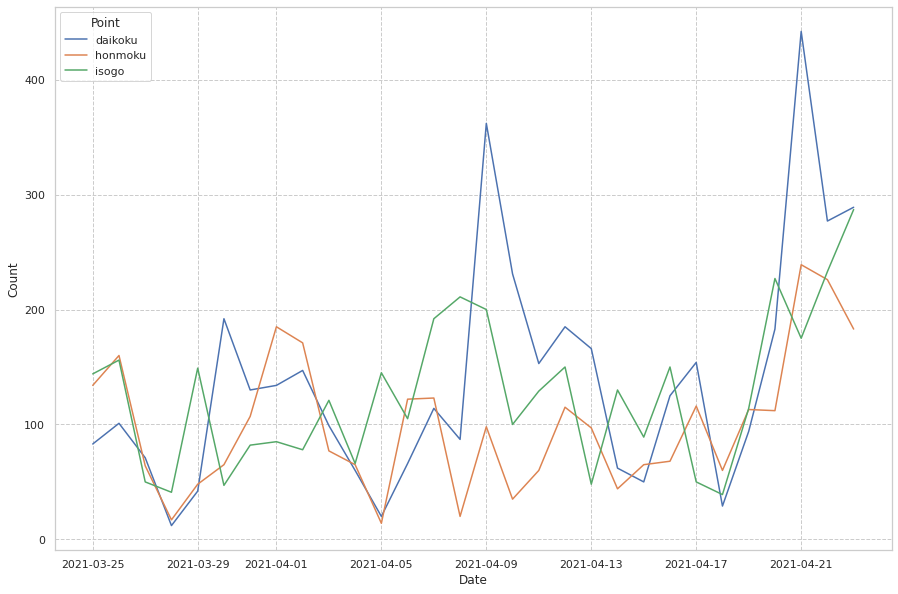

In [21]:
# アジの釣果数
sns.lineplot(data=df2.query('Species=="Aji"'), x="Date", y="Count", hue="Point", ci=None)

<AxesSubplot:xlabel='Date', ylabel='SizeMax'>

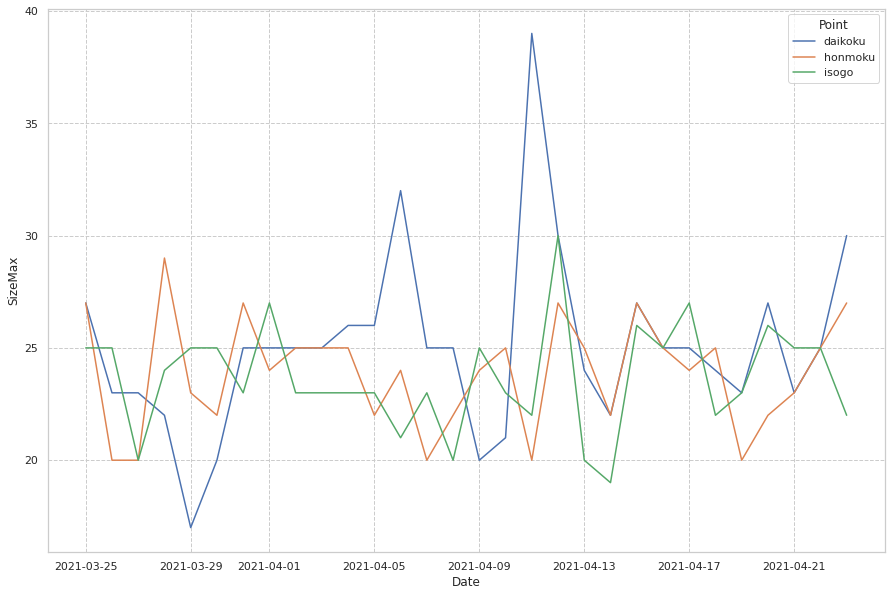

In [24]:
# アジの釣果サイズ（最大）
sns.lineplot(data=df2.query('Species=="Aji"'), x="Date", y="SizeMax", hue="Point")

<AxesSubplot:xlabel='Date', ylabel='Count'>

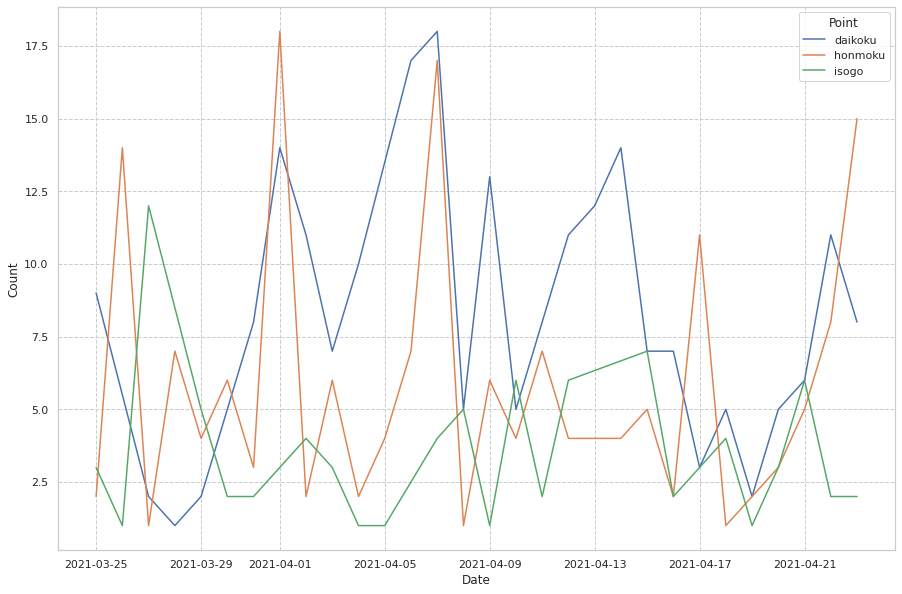

In [25]:
# クロダイの釣果数
sns.lineplot(data=df2.query('Species=="Kurodai"'), x="Date", y="Count", hue="Point")

<AxesSubplot:xlabel='Date', ylabel='SizeMax'>

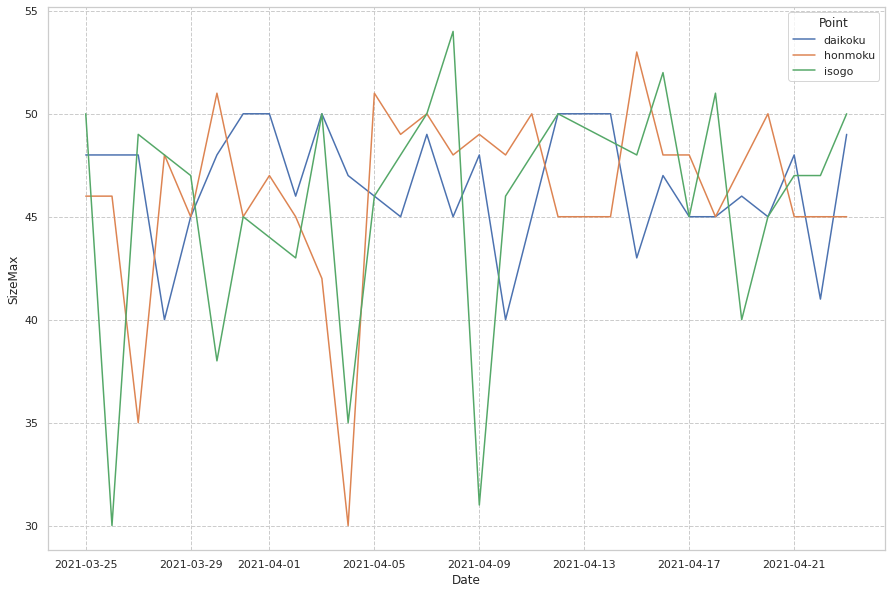

In [26]:
# クロダイの釣果サイズ（最大）
sns.lineplot(data=df2.query('Species=="Kurodai"'), x="Date", y="SizeMax", hue="Point")